## SFN 24 Results Explorer2

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *
from sim import multi_sim_run
from sim import plot

In [4]:
# overall imports
import importlib
import data

# data load
importlib.reload(data.data_load)
from data.data_load import load_transcriptome, load_connectome
importlib.reload(data.data_load)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, single_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

import sim.plot
from sim.plot import (
    plot_predictions, 
    barplot_model_performance,
    boxplot_model_performance,
    plot_predictions_with_metrics, plot_single_model_predictions_with_metrics,
    plot_best_params_table, plot_best_parameters_table_colored, 
    violin_plot_model_performance, 
    plot_transcriptome_performance_bar, plot_connectome_performance_bar, 
    plot_combined_performance_bar
)

importlib.reload(sim.plot)


<module 'sim.plot' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/plot.py'>

#### Check job specs

In [5]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.showUtilization()


CPU Usage: 0.1%
RAM Usage: 6.0%
Available RAM: 354.3G
Total RAM: 376.8G
52.4G


RuntimeError: Could not find an available GPU after 1 attempts with 900 seconds interval.

## Table of Contents
- [Random](#Random)
- [Community](#Community)
    - [Single Feature](#single)
    - [Combined_Feature](#combined)

## Random

In [10]:
SFN_sim_path = os.getcwd() + '/sim/sim_results/'
os.listdir(SFN_sim_path)

feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean', 'functional']

In [11]:
def extract_simulation_metrics(sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions=[], seeds=[]):
    """
    Extracts simulation results from pickle files and computes the average Pearson correlation,
    MSE, and standard error over all the folds for the specified parameters.
    
    Args:
    - sim_path: Base directory for the simulations.
    - subfolder: Subfolder within sim_path where simulation results are stored.
    - model_type: The model type used (e.g., 'xgboost', 'pls').
    - cv_type: The cross-validation type (e.g., 'random', 'community').
    - search_method: The search method used (e.g., 'bayessearch', 'gridsearch').
    - feature_types: List of feature types used in simulations (e.g., 'transcriptome', 'euclidean').
    - resolutions: List of resolution values used in simulations. (Can be empty for wildcard)
    - seeds: List of random seed values used in simulations. (Can be empty for wildcard)
    
    Returns:
    - A pandas DataFrame containing the file names and the average Pearson correlation,
      MSE, and standard error for each file.
    """
    
    data = []  # List to store the results
    
    # If resolutions or seeds are empty, set them to a wildcard [''] to ignore the filter
    if not resolutions:
        resolutions = ['']
    if not seeds:
        seeds = ['']
    
    # Iterate over feature types, resolutions, and seeds
    for feature in feature_types:
        for r in resolutions:
            for s in seeds:
                # Construct the expected pickle file name pattern
                resolution_str = str(r).replace('.', '') if r else ''  # If resolution is empty, skip it in the filename
                seed_str = str(s) if s else ''  # If seed is empty, skip it in the filename
                file_pattern = f"{feature}_{model_type}_{cv_type}{resolution_str}_{seed_str}_{search_method}.pickle"
                file_path = os.path.join(sim_path, subfolder, file_pattern)
                
                # Check if the file exists
                if os.path.exists(file_path):
                    # Open the pickle file and load the results
                    with open(file_path, 'rb') as f:
                        results = pickle.load(f)
                    
                    # Extract the metrics for each fold
                    pearson_corrs = []
                    mses = []
                    for fold_result in results[0]:  # Assuming the results are stored in the first element
                        pearson_corrs.append(fold_result['test_metrics']['pearson_corr'])
                        mses.append(fold_result['test_metrics']['mse'])
                    
                    # Compute the mean and standard error
                    mean_pearson_corr = np.mean(pearson_corrs)
                    mean_mse = np.mean(mses)
                    std_err_pearson_corr = np.std(pearson_corrs) / np.sqrt(len(pearson_corrs))
                    std_err_mse = np.std(mses) / np.sqrt(len(mses))
                    
                    # Append the results to the data list
                    data.append({
                        'File Name': file_pattern,
                        'Feature Type': feature,
                        'Mean Pearson Corr': mean_pearson_corr,
                        'Std Err Pearson Corr': std_err_pearson_corr,
                        'Mean MSE': mean_mse,
                        'Std Err MSE': std_err_mse
                    })
                else:
                    print(f"File not found: {file_pattern}")
    
    # Create a DataFrame from the data
    df_results = pd.DataFrame(data)
    
    return df_results

def plot_feature_comparison(df, metric='pearson_corr', margin_factor=0.2):
    """
    Function to create a barplot comparing the performance (Pearson correlation or MSE)
    of different feature types averaged over multiple seeds.

    Args:
    - df: Pandas DataFrame with columns 'Feature Type', 'Mean Pearson Corr', 'Mean MSE', and corresponding std errors.
    - metric: The metric to display, either 'pearson_corr' or 'mse'.
    """
    # Validate metric input
    if metric not in ['pearson_corr', 'mse']:
        raise ValueError("Invalid metric. Choose either 'pearson_corr' or 'mse'.")
    
    # Select the appropriate column based on the chosen metric
    if metric == 'pearson_corr':
        score_column = 'Mean Pearson Corr'
        error_column = 'Std Err Pearson Corr'
        ylabel = 'Pearson Correlation'
    else:
        score_column = 'Mean MSE'
        error_column = 'Std Err MSE'
        ylabel = 'Mean Squared Error (MSE)'
    
    # Group by feature type and calculate the mean and standard error
    df_grouped = df.groupby('Feature Type').agg(
        mean_score=(score_column, 'mean'),
        std_err=(error_column, 'mean')
    ).reset_index()

    # Set the style for an academic journal-style plot
    sns.set(style="whitegrid", context="paper")
    
    # Create the bar plot
    plt.figure(figsize=(8, 6))
    bar_plot = sns.barplot(x='Feature Type', y='mean_score', data=df_grouped, 
                           ci=None, capsize=0.1, edgecolor='black')
    
    # Add error bars manually
    plt.errorbar(x=df_grouped['Feature Type'], y=df_grouped['mean_score'], 
                 yerr=df_grouped['std_err'], fmt='none', c='black', capsize=5)

    # Customize the plot for journal-style aesthetics
    bar_plot.set_title(f'Comparison of Feature Types ({ylabel})', fontsize=14)
    bar_plot.set_xlabel('Feature Type', fontsize=14)
    bar_plot.set_ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=30, ha="right", fontsize=14)
    plt.yticks(fontsize=10)
    
    # Calculate the dynamic upper limit
    max_value = df_grouped['mean_score'].max()
    dynamic_ylim = max_value + (max_value * margin_factor)
    # Set dynamic y-axis limit
    plt.ylim(0, dynamic_ylim)
    
    # Remove the gridlines for a cleaner look
    sns.despine()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

import pandas as pd
from IPython.display import display

def display_results_table(df, feature_types):
    """
    Function to display results in a table format where the first row is the mean Pearson correlation ± std error,
    and the second row is the mean MSE ± std error for each feature type. The best value for Pearson correlation (highest)
    and MSE (lowest) will be bolded.
    
    Args:
    - df: DataFrame containing the results for different feature types.
    - feature_types: List of feature types to include in the table.
    
    Returns:
    - Displays the formatted table.
    """
    
    # Initialize lists to store the mean Pearson correlations, MSE values, and their standard errors
    pearson_corr_means = []
    mse_means = []
    
    # Store numerical values for comparison later
    pearson_corr_values = []
    mse_values = []
    
    # Iterate over each feature type and extract the corresponding mean and std error values
    for feature in feature_types:
        # Filter the DataFrame for the current feature type
        feature_df = df[df['Feature Type'] == feature]
        
        # Compute the mean and std error for Pearson correlation and MSE
        mean_pearson_corr = feature_df['Mean Pearson Corr'].mean()
        std_err_pearson_corr = feature_df['Std Err Pearson Corr'].mean()
        
        mean_mse = feature_df['Mean MSE'].mean()
        std_err_mse = feature_df['Std Err MSE'].mean()
        
        # Store values for later comparison
        pearson_corr_values.append(mean_pearson_corr)
        mse_values.append(mean_mse)
        
        # Format as "mean ± std_error" for both Pearson correlation and MSE
        pearson_corr_means.append(f"{mean_pearson_corr:.3f} ± {std_err_pearson_corr:.3f}")
        mse_means.append(f"{mean_mse:.4f} ± {std_err_mse:.4f}")
    
    # Determine the best values for Pearson correlation (max) and MSE (min)
    best_pearson_idx = np.argmax(pearson_corr_values)  # Index of the highest Pearson correlation
    best_mse_idx = np.argmin(mse_values)  # Index of the lowest MSE
    
    # Bold the best values
    pearson_corr_means[best_pearson_idx] = f"**{pearson_corr_means[best_pearson_idx]}**"
    mse_means[best_mse_idx] = f"**{mse_means[best_mse_idx]}**"
    
    # Create a DataFrame to store the results
    table_df = pd.DataFrame({
        'Feature Type': feature_types,
        'Pearson Correlation': pearson_corr_means,
        'MSE': mse_means
    }).set_index('Feature Type')
    
    # Transpose the table to display metrics as rows and feature types as columns
    table_df_transposed = table_df.T
    
    # Display the table
    display(table_df_transposed)

    return table_df_transposed

XGBoost

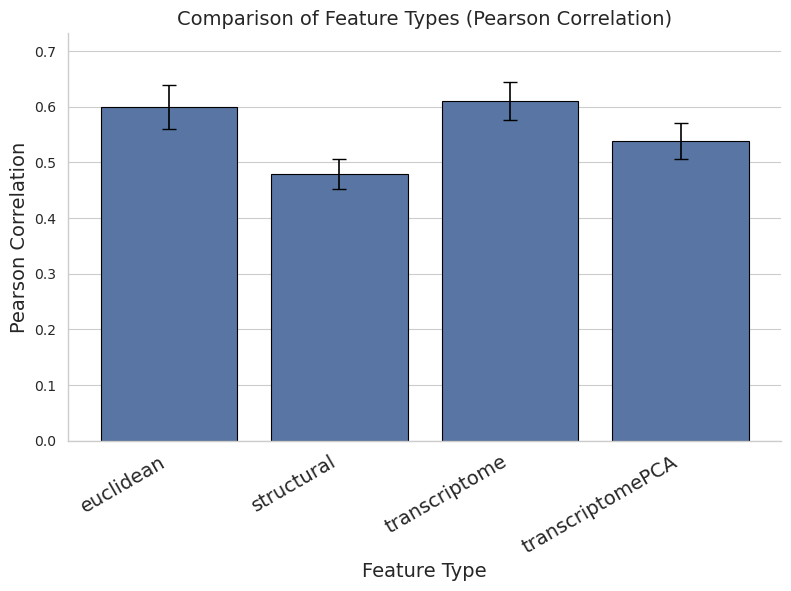

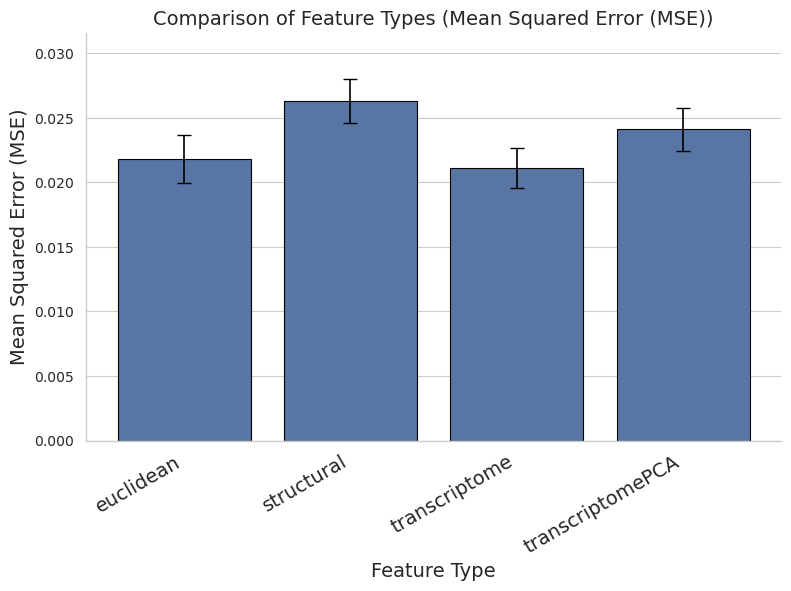

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,**0.610 ± 0.033**,0.539 ± 0.032,0.479 ± 0.027,0.599 ± 0.039
MSE,**0.0211 ± 0.0016**,0.0241 ± 0.0017,0.0263 ± 0.0017,0.0218 ± 0.0018


In [12]:
# Base simulation path
SFN_sim_path = os.getcwd() + '/sim/sim_results/SFN_runs_mse'

# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'random'
search_method = 'bayessearch'
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = []  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]  # List of seeds

random_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
random_split_results

plot_feature_comparison(random_split_results, metric='pearson_corr') 
plot_feature_comparison(random_split_results, metric='mse')

xgboost_random_df =display_results_table(random_split_results, feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean'])

PLS

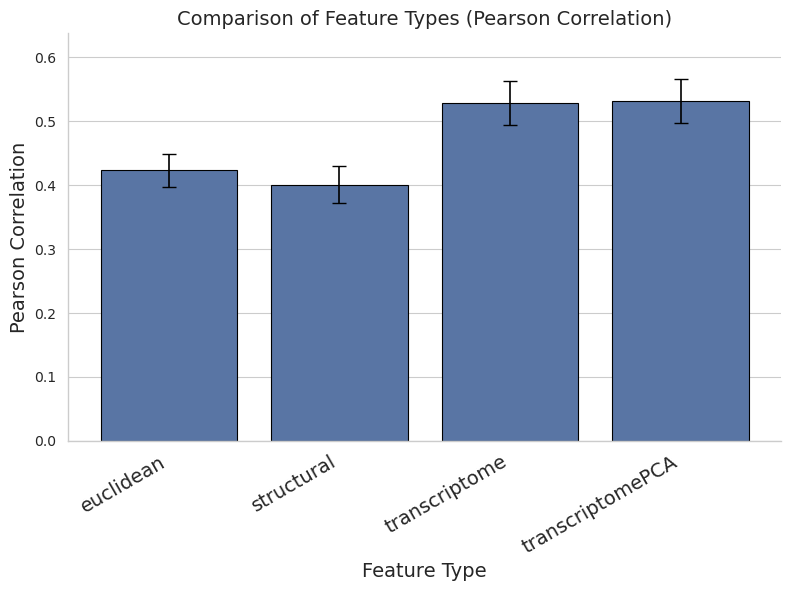

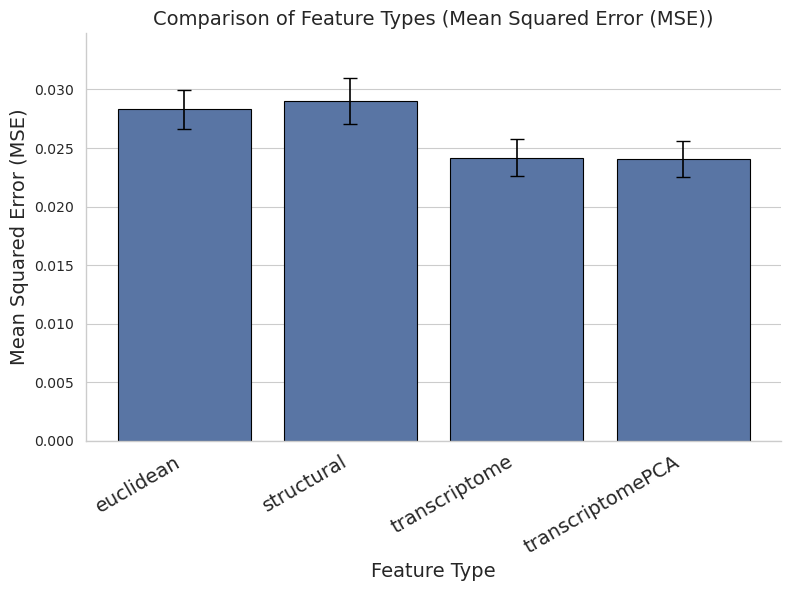

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,0.529 ± 0.034,**0.532 ± 0.034**,0.401 ± 0.028,0.423 ± 0.026
MSE,0.0242 ± 0.0016,**0.0241 ± 0.0015**,0.0290 ± 0.0020,0.0283 ± 0.0016


In [13]:
# Base simulation path
SFN_sim_path = os.getcwd() + '/sim/sim_results/SFN_runs_mse'

# Specify parameters
subfolder = ''
model_type = 'pls'
cv_type = 'random'
search_method = 'gridsearch'
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = []  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]  # List of seeds

random_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
random_split_results

plot_feature_comparison(random_split_results, metric='pearson_corr') 
plot_feature_comparison(random_split_results, metric='mse')

pls_random_df =display_results_table(random_split_results, feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean'])

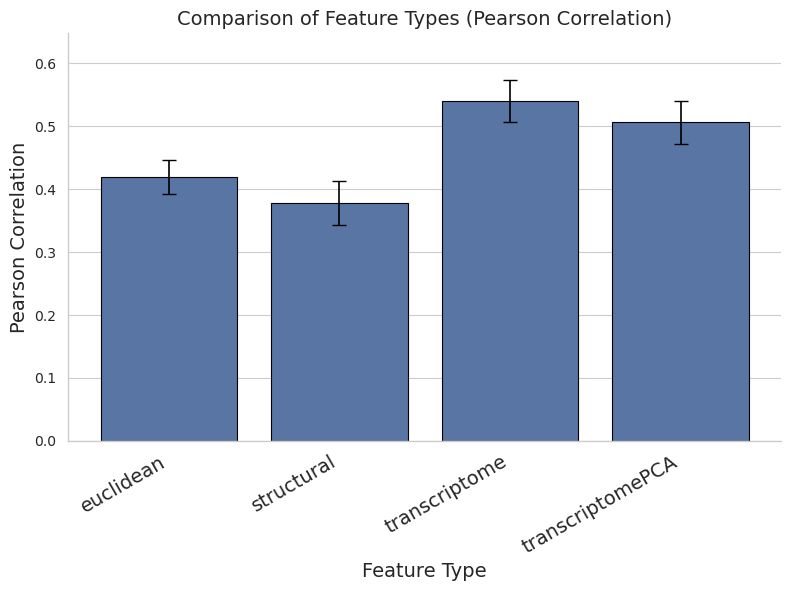

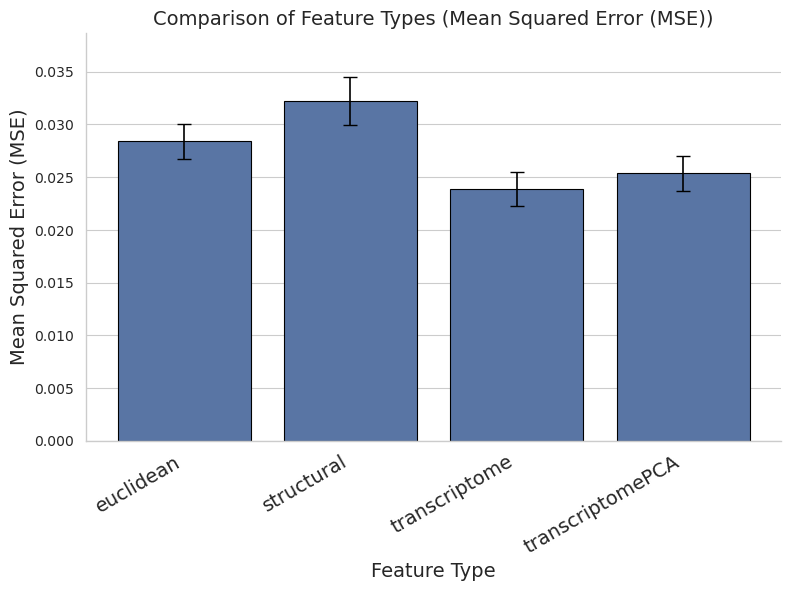

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,**0.540 ± 0.033**,0.506 ± 0.034,0.378 ± 0.035,0.420 ± 0.027
MSE,**0.0239 ± 0.0016**,0.0254 ± 0.0017,0.0322 ± 0.0023,0.0284 ± 0.0017


In [14]:
# Base simulation path
SFN_sim_path = os.getcwd() + '/sim/sim_results/SFN_runs_mse'

# Specify parameters
subfolder = ''
model_type = 'ridge'
cv_type = 'random'
search_method = 'gridsearch'
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = []  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]  # List of seeds

random_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
random_split_results

plot_feature_comparison(random_split_results, metric='pearson_corr') 
plot_feature_comparison(random_split_results, metric='mse')

ridge_random_df = display_results_table(random_split_results, feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean'])

In [159]:


def plot_combined_model_performance(dfs, model_types, metric='pearson_corr', use_grayscale=True):
    """
    Plots a combined bar chart of model performance across different features for different model types.
    
    Args:
    - dfs: List of DataFrames, where each DataFrame corresponds to one model type.
    - model_types: List of model names (in order corresponding to the DataFrames).
    - metric: The performance metric to plot ('pearson_corr' or 'mse').
    - use_grayscale: Boolean flag to switch between grayscale and soft colors.
    
    Returns:
    - A combined bar chart of performance metrics with error bars.
    """
    
    # Initialize an empty list to store the bar plot data
    plot_data = []

    # Mapping metric to DataFrame row name
    metric_mapping = {
        'pearson_corr': 'Pearson Correlation',
        'mse': 'MSE'
    }
    
    # Convert string metric input to proper DataFrame row name
    metric_row_name = metric_mapping.get(metric.lower(), 'Pearson Correlation')

    # Ensure the metric is valid
    if metric_row_name not in ['Pearson Correlation', 'MSE']:
        raise ValueError("Metric must be 'pearson_corr' or 'mse'")
    
    # Extract feature types from the first dataframe
    feature_types = dfs[0].columns

    # Iterate through each DataFrame, extracting the values and errors
    for i, df in enumerate(dfs):
        mean_values = []
        errors = []

        for feature in feature_types:
            # Get mean and error by splitting the "mean ± std_error" format
            value_error_str = df.loc[metric_row_name, feature].replace("**", "")
            mean_value, error_value = value_error_str.split(" ± ")
            mean_values.append(float(mean_value))
            errors.append(float(error_value))

        plot_data.append((mean_values, errors))
    
    # Set up bar chart configuration
    num_models = len(model_types)
    num_features = len(feature_types)
    bar_width = 0.2
    x_indices = np.arange(num_features)

    # Set grayscale colors or soft colors for the bars
    if use_grayscale:
        gray_colors = ['#737373', '#bdbdbd', '#d9d9d9', '#525252']  # Grayscale shades
        colors = gray_colors[:num_models]
    else:
        # Use seaborn's pastel palette for soft colors
        soft_colors = sns.color_palette('pastel', num_models)
        colors = soft_colors

    # Create the plot
    plt.figure(figsize=(12, 5))  # Bigger figure size
    
    # Plot bars for each model type
    for i, (mean_values, errors) in enumerate(plot_data):
        plt.bar(x_indices + i * bar_width, mean_values, bar_width, yerr=errors, 
                label=model_types[i], color=colors[i % len(colors)], 
                capsize=5, edgecolor='black')
        #print(colors[i % len(colors)])

    # Set x-axis labels and legend
    plt.xticks(x_indices + (num_models - 1) * bar_width / 2, feature_types, fontsize=24, rotation=30)  # Increase font size
    plt.yticks(fontsize=20)  # Increase font size
    #plt.xlabel('Feature Type', fontsize=16)  # Increase font size
    if metric_row_name == 'Pearson Correlation':    
        plt.ylabel('Pearson r', fontsize=26)  # Increase font size
    else:
        plt.ylabel(f'{metric_row_name}', fontsize=26)  # Increase font size
    #plt.title(f'Model Performance Comparison ({metric_row_name})', fontsize=18)  # Increase font size

    # Move legend outside the plot
    plt.legend(title='Model Type', fontsize=22, title_fontsize=22, loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside plot
    
    # Show the plot with tight layout
    # Remove gridlines
    plt.grid(False)
    
    # Adjust y-axis range for Pearson correlation
    if metric == 'pearson_corr':
        plt.ylim(0.0, 0.75)# max([max(m) for m, _ in plot_data]) + 0.1)  # Slightly increase the upper limit
    else: 
        plt.ylim(0.0, 0.15)
        
    # Show the plot
    plt.tight_layout()
    # plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the external legend
    plt.show()
    '''
    # Set x-axis labels and legend
    plt.xticks(x_indices + (num_models - 1) * bar_width / 2, [ftype.replace(" ", "+") for ftype in feature_types], fontsize=22, rotation=45, ha="right")  # Increase font size and rotate labels
    plt.yticks(fontsize=20)  # Increase font size
    plt.ylabel(f'{metric_row_name}', fontsize=24)  # Increase font size
    
    # Move legend outside the plot
    plt.legend(title='Model Type', fontsize=20, title_fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside plot
    
    # Remove gridlines
    plt.grid(False)
    
    # Adjust y-axis range for Pearson correlation
    if metric == 'pearson_corr':
        plt.ylim(0.0, 0.75)  # Adjust upper limit slightly above max value

    # Show the plot with tight layout
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the external legend
    plt.show()
    '''
'''
def plot_combined_model_performance(dfs, model_types, metric='pearson_corr'):
    """
    Plots a combined bar chart of model performance across different features for different model types.
    
    Args:
    - dfs: List of DataFrames, where each DataFrame corresponds to one model type.
    - model_types: List of model names (in order corresponding to the DataFrames).
    - metric: The performance metric to plot ('pearson_corr' or 'mse').
    
    Returns:
    - A combined bar chart of performance metrics with error bars.
    """
    
    # Initialize an empty list to store the bar plot data
    plot_data = []

    # Mapping metric to DataFrame row name
    metric_mapping = {
        'pearson_corr': 'Pearson Correlation',
        'mse': 'MSE'
    }
    
    # Convert string metric input to proper DataFrame row name
    metric_row_name = metric_mapping.get(metric.lower(), 'Pearson Correlation')

    # Ensure the metric is valid
    if metric_row_name not in ['Pearson Correlation', 'MSE']:
        raise ValueError("Metric must be 'pearson_corr' or 'mse'")
    
    # Extract feature types from the first dataframe
    feature_types = dfs[0].columns

    # Iterate through each DataFrame, extracting the values and errors
    for i, df in enumerate(dfs):
        mean_values = []
        errors = []

        for feature in feature_types:
            # Get mean and error by splitting the "mean ± std_error" format
            value_error_str = df.loc[metric_row_name, feature].replace("**", "")
            mean_value, error_value = value_error_str.split(" ± ")
            mean_values.append(float(mean_value))
            errors.append(float(error_value))

        plot_data.append((mean_values, errors))

    # Set up bar chart configuration
    num_models = len(model_types)
    num_features = len(feature_types)
    bar_width = 0.2
    x_indices = np.arange(num_features)
    
    # Set grayscale colors for the bars
    gray_colors = ['#737373', '#bdbdbd', '#d9d9d9', '#525252']  # Adjust shades for each model type
    colors = []
    # Create the plot
    plt.figure(figsize=(12, 5))  # Bigger figure size
    
    # Plot bars for each model type
    for i, (mean_values, errors) in enumerate(plot_data):
        plt.bar(x_indices + i * bar_width, mean_values, bar_width, yerr=errors, 
                label=model_types[i], color=gray_colors[i % len(gray_colors)], 
                capsize=5, edgecolor='black')

    # Set x-axis labels and legend
    plt.xticks(x_indices + (num_models - 1) * bar_width / 2, feature_types, fontsize=22)  # Increase font size
    plt.yticks(fontsize=20)  # Increase font size
    #plt.xlabel('Feature Type', fontsize=16)  # Increase font size
    plt.ylabel(f'{metric_row_name}', fontsize=24)  # Increase font size
    #plt.title(f'Model Performance Comparison ({metric_row_name})', fontsize=18)  # Increase font size
    plt.legend(title='Model Type', fontsize=20, title_fontsize=20)  # Bigger font for the legend
    
    # Remove gridlines
    plt.grid(False)
    
    # Adjust y-axis range for Pearson correlation
    if metric == 'pearson_corr':
        plt.ylim(0.0, 0.75)# max([max(m) for m, _ in plot_data]) + 0.1)  # Slightly increase the upper limit

    # Show the plot
    plt.tight_layout()
    plt.show()
'''

'\ndef plot_combined_model_performance(dfs, model_types, metric=\'pearson_corr\'):\n    """\n    Plots a combined bar chart of model performance across different features for different model types.\n    \n    Args:\n    - dfs: List of DataFrames, where each DataFrame corresponds to one model type.\n    - model_types: List of model names (in order corresponding to the DataFrames).\n    - metric: The performance metric to plot (\'pearson_corr\' or \'mse\').\n    \n    Returns:\n    - A combined bar chart of performance metrics with error bars.\n    """\n    \n    # Initialize an empty list to store the bar plot data\n    plot_data = []\n\n    # Mapping metric to DataFrame row name\n    metric_mapping = {\n        \'pearson_corr\': \'Pearson Correlation\',\n        \'mse\': \'MSE\'\n    }\n    \n    # Convert string metric input to proper DataFrame row name\n    metric_row_name = metric_mapping.get(metric.lower(), \'Pearson Correlation\')\n\n    # Ensure the metric is valid\n    if metric

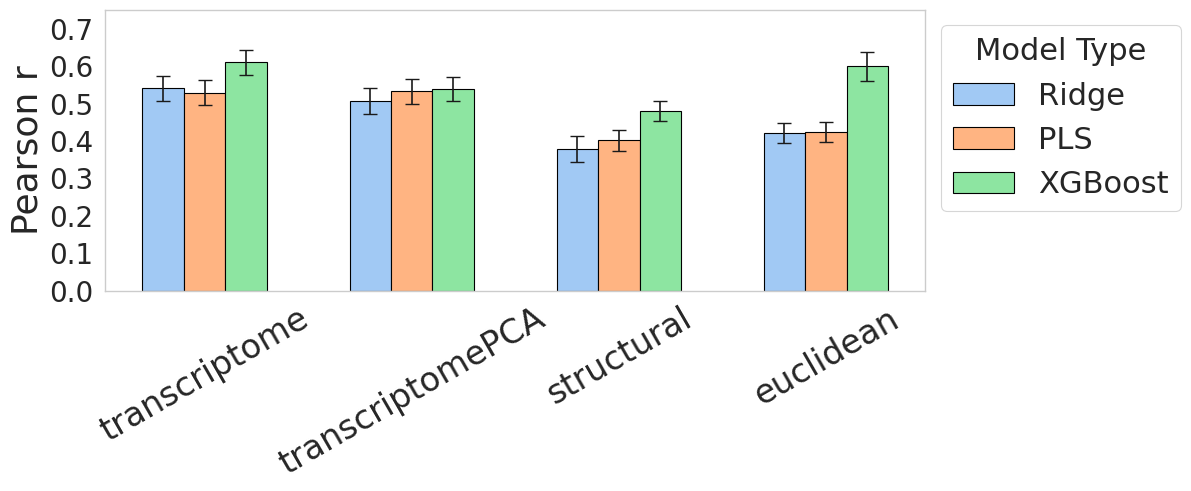

In [139]:

# Example usage with your 3 dataframes
plot_combined_model_performance([ridge_random_df, pls_random_df, xgboost_random_df], 
                                model_types=['Ridge', 'PLS', 'XGBoost'], 
                                metric='pearson_corr', 
                               use_grayscale=False)

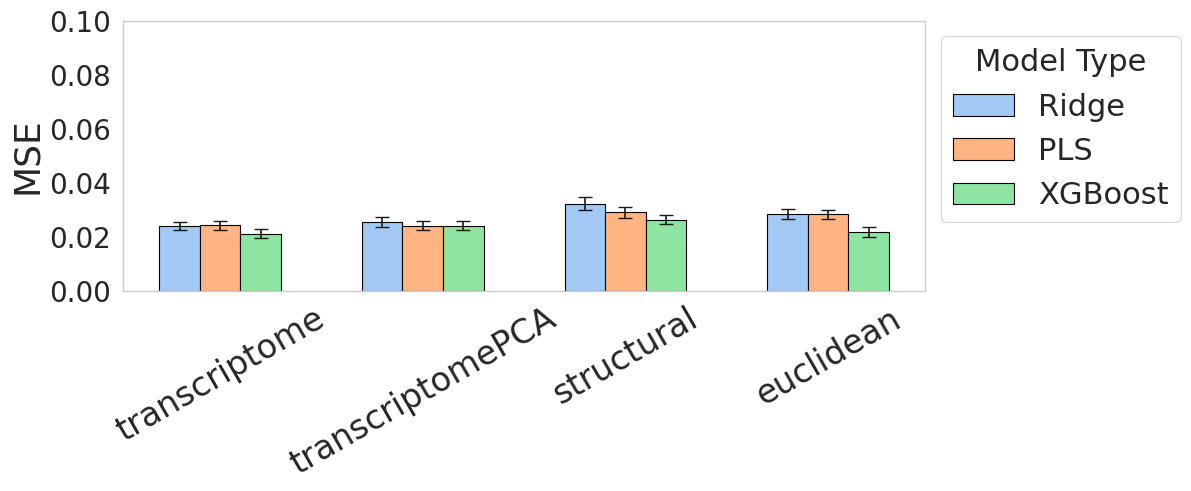

In [141]:
# Example usage with your 3 dataframes
plot_combined_model_performance([ridge_random_df, pls_random_df, xgboost_random_df], 
                                model_types=['Ridge', 'PLS', 'XGBoost'], 
                                metric='mse', 
                                use_grayscale=False)

## Community

                                            File Name      Feature Type  \
0   transcriptome_xgboost_community101_1_bayessear...     transcriptome   
1   transcriptome_xgboost_community101_2_bayessear...     transcriptome   
2   transcriptome_xgboost_community101_4_bayessear...     transcriptome   
3   transcriptome_xgboost_community101_5_bayessear...     transcriptome   
4   transcriptome_xgboost_community101_42_bayessea...     transcriptome   
5   transcriptomePCA_xgboost_community101_1_bayess...  transcriptomePCA   
6   transcriptomePCA_xgboost_community101_2_bayess...  transcriptomePCA   
7   transcriptomePCA_xgboost_community101_4_bayess...  transcriptomePCA   
8   transcriptomePCA_xgboost_community101_5_bayess...  transcriptomePCA   
9   transcriptomePCA_xgboost_community101_42_bayes...  transcriptomePCA   
10  structural_xgboost_community101_1_bayessearch....        structural   
11  structural_xgboost_community101_2_bayessearch....        structural   
12  structural_xgboost_co

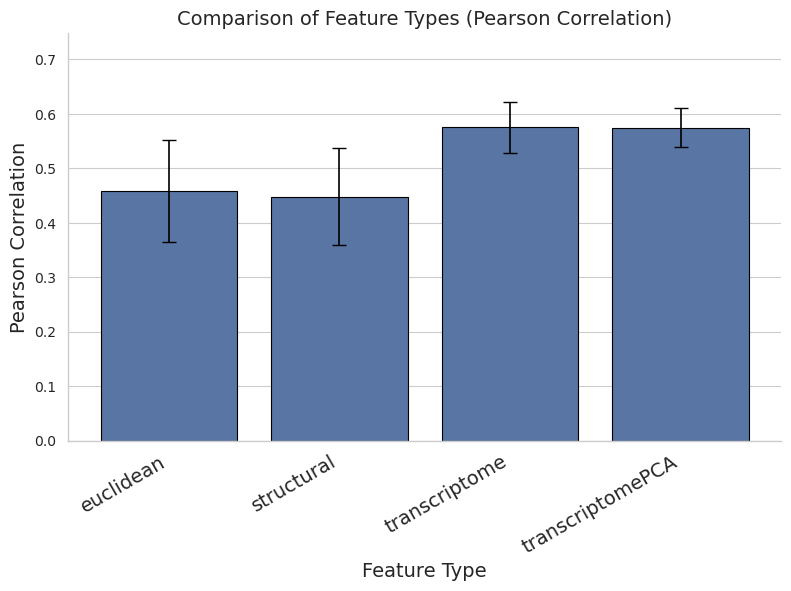

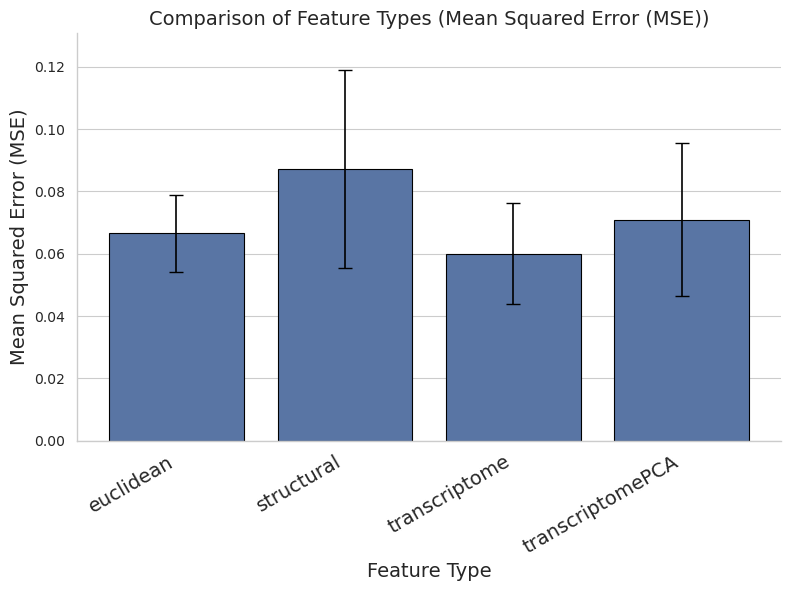

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,**0.576 ± 0.047**,0.575 ± 0.036,0.448 ± 0.089,0.459 ± 0.094
MSE,**0.0599 ± 0.0162**,0.0709 ± 0.0245,0.0872 ± 0.0317,0.0665 ± 0.0124


In [153]:
# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'community'
search_method = 'bayessearch'
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3)  # To plot Pearson correlation
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5)  # To plot MSE

xgboost_community_df = display_results_table(community_split_results, feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean'])

                                            File Name      Feature Type  \
0   transcriptome_ridge_community101_1_gridsearch....     transcriptome   
1   transcriptome_ridge_community101_2_gridsearch....     transcriptome   
2   transcriptome_ridge_community101_4_gridsearch....     transcriptome   
3   transcriptome_ridge_community101_5_gridsearch....     transcriptome   
4   transcriptome_ridge_community101_42_gridsearch...     transcriptome   
5   transcriptomePCA_ridge_community101_1_gridsear...  transcriptomePCA   
6   transcriptomePCA_ridge_community101_2_gridsear...  transcriptomePCA   
7   transcriptomePCA_ridge_community101_4_gridsear...  transcriptomePCA   
8   transcriptomePCA_ridge_community101_5_gridsear...  transcriptomePCA   
9   transcriptomePCA_ridge_community101_42_gridsea...  transcriptomePCA   
10  structural_ridge_community101_1_gridsearch.pickle        structural   
11  structural_ridge_community101_2_gridsearch.pickle        structural   
12  structural_ridge_comm

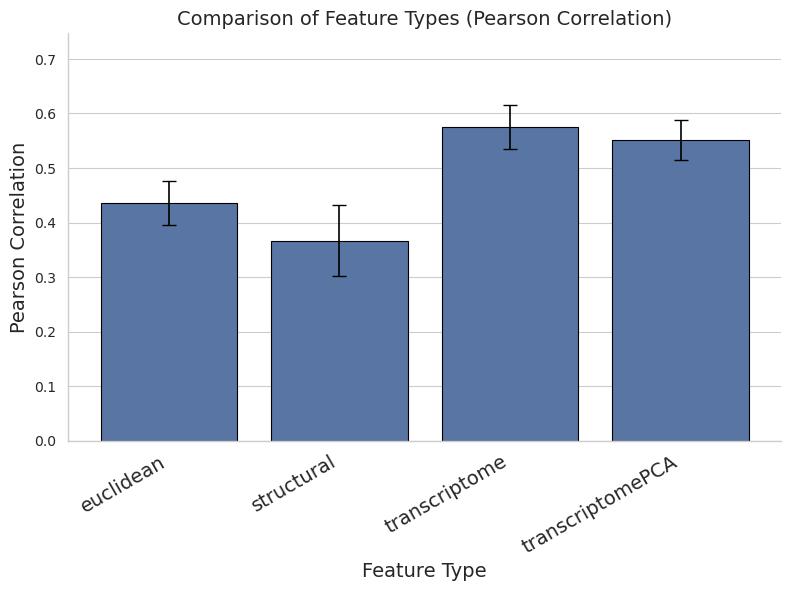

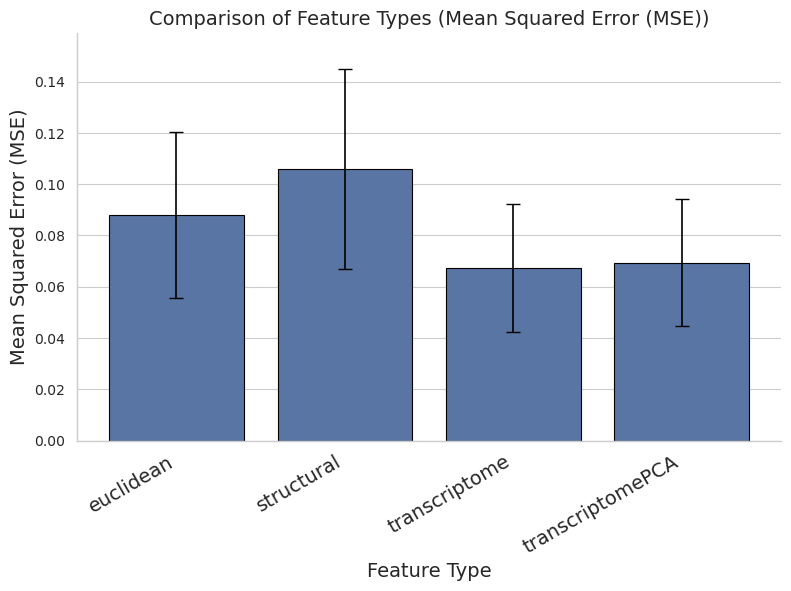

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,**0.575 ± 0.040**,0.551 ± 0.037,0.367 ± 0.065,0.436 ± 0.040
MSE,**0.0672 ± 0.0250**,0.0693 ± 0.0248,0.1059 ± 0.0390,0.0879 ± 0.0325


In [154]:
# Specify parameters
subfolder = ''
model_type = 'ridge'
cv_type = 'community'
search_method = 'gridsearch'
feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5) 

ridge_community_df = display_results_table(community_split_results, feature_types=feature_types)

                                            File Name      Feature Type  \
0   transcriptome_pls_community101_1_gridsearch.pi...     transcriptome   
1   transcriptome_pls_community101_2_gridsearch.pi...     transcriptome   
2   transcriptome_pls_community101_4_gridsearch.pi...     transcriptome   
3   transcriptome_pls_community101_5_gridsearch.pi...     transcriptome   
4   transcriptome_pls_community101_42_gridsearch.p...     transcriptome   
5   transcriptomePCA_pls_community101_1_gridsearch...  transcriptomePCA   
6   transcriptomePCA_pls_community101_2_gridsearch...  transcriptomePCA   
7   transcriptomePCA_pls_community101_4_gridsearch...  transcriptomePCA   
8   transcriptomePCA_pls_community101_5_gridsearch...  transcriptomePCA   
9   transcriptomePCA_pls_community101_42_gridsearc...  transcriptomePCA   
10    structural_pls_community101_1_gridsearch.pickle        structural   
11    structural_pls_community101_2_gridsearch.pickle        structural   
12    structural_pls_comm

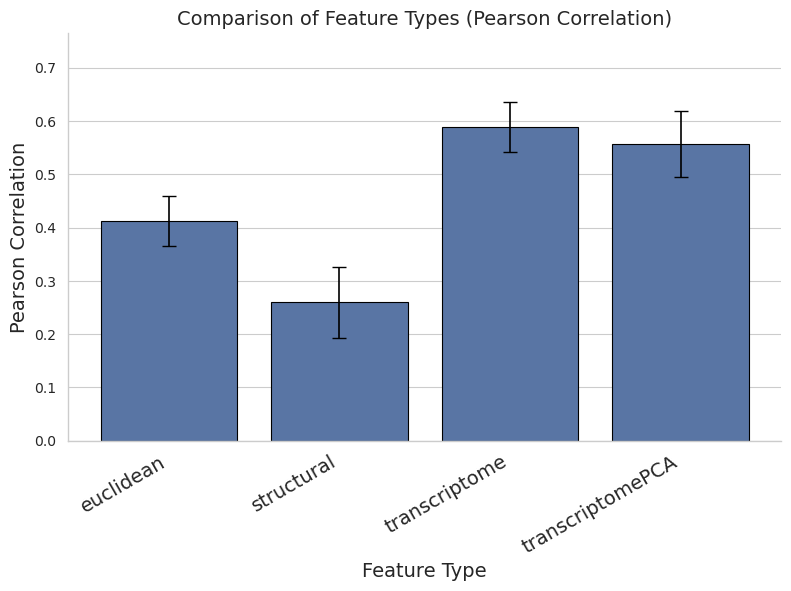

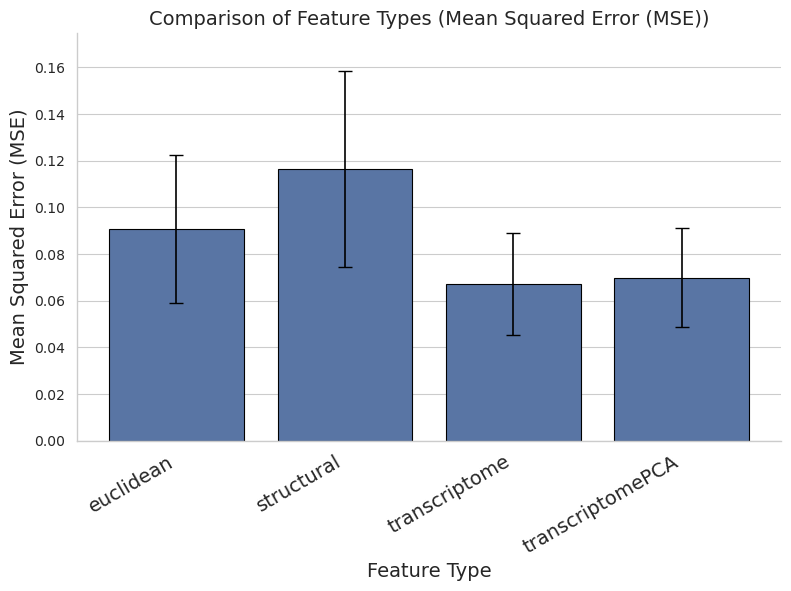

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,**0.588 ± 0.047**,0.557 ± 0.062,0.260 ± 0.066,0.413 ± 0.047
MSE,**0.0670 ± 0.0219**,0.0698 ± 0.0211,0.1164 ± 0.0420,0.0905 ± 0.0317


In [155]:
# Specify parameters
subfolder = ''
model_type = 'pls'
cv_type = 'community'
search_method = 'gridsearch'
feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5) 

pls_community_df = display_results_table(community_split_results, feature_types=feature_types)

In [156]:

# def plot_combined_model_performance(dfs, model_types, metric='pearson_corr'):
#     """
#     Plots a combined bar chart of model performance across different features for different model types.
    
#     Args:
#     - dfs: List of DataFrames, where each DataFrame corresponds to one model type.
#     - model_types: List of model names (in order corresponding to the DataFrames).
#     - metric: The performance metric to plot ('pearson_corr' or 'mse').
    
#     Returns:
#     - A combined bar chart of performance metrics with error bars.
#     """
    
#     # Initialize an empty list to store the bar plot data
#     plot_data = []

#     # Mapping metric to DataFrame row name
#     metric_mapping = {
#         'pearson_corr': 'Pearson Correlation',
#         'mse': 'MSE'
#     }
    
#     # Convert string metric input to proper DataFrame row name
#     metric_row_name = metric_mapping.get(metric.lower(), 'Pearson Correlation')

#     # Ensure the metric is valid
#     if metric_row_name not in ['Pearson Correlation', 'MSE']:
#         raise ValueError("Metric must be 'pearson_corr' or 'mse'")
    
#     # Extract feature types from the first dataframe
#     feature_types = dfs[0].columns

#     # Iterate through each DataFrame, extracting the values and errors
#     for i, df in enumerate(dfs):
#         mean_values = []
#         errors = []

#         for feature in feature_types:
#             # Get mean and error by splitting the "mean ± std_error" format
#             value_error_str = df.loc[metric_row_name, feature].replace("**", "")
#             mean_value, error_value = value_error_str.split(" ± ")
#             mean_values.append(float(mean_value))
#             errors.append(float(error_value))

#         plot_data.append((mean_values, errors))

#     # Set up bar chart configuration
#     num_models = len(model_types)
#     num_features = len(feature_types)
#     bar_width = 0.2
#     x_indices = np.arange(num_features)
    
#     # Set grayscale colors for the bars
#     gray_colors = ['#737373', '#bdbdbd', '#d9d9d9', '#525252']  # Adjust shades for each model type
    
#     # Create the plot
#     plt.figure(figsize=(12, 6))  # Bigger figure size
    
#     # Plot bars for each model type
#     for i, (mean_values, errors) in enumerate(plot_data):
#         plt.bar(x_indices + i * bar_width, mean_values, bar_width, yerr=errors, 
#                 label=model_types[i], color=gray_colors[i % len(gray_colors)], 
#                 capsize=5, edgecolor='black')

#     # Set x-axis labels and legend
#     plt.xticks(x_indices + (num_models - 1) * bar_width / 2, feature_types, fontsize=16)  # Increase font size
#     plt.yticks(fontsize=16)  # Increase font size
#     plt.xlabel('Feature Type', fontsize=16)  # Increase font size
#     plt.ylabel(f'{metric_row_name}', fontsize=16)  # Increase font size
#     #plt.title(f'Model Performance Comparison ({metric_row_name})', fontsize=18)  # Increase font size
#     plt.legend(title='Model Type', fontsize=14, title_fontsize=14)  # Bigger font for the legend
    
#     # Remove gridlines
#     plt.grid(False)
    
#     # Adjust y-axis range for Pearson correlation
#     if metric == 'pearson_corr':
#         plt.ylim(0, 0.75) #max([max(m) for m, _ in plot_data]) + 0.1)  # Slightly increase the upper limit

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

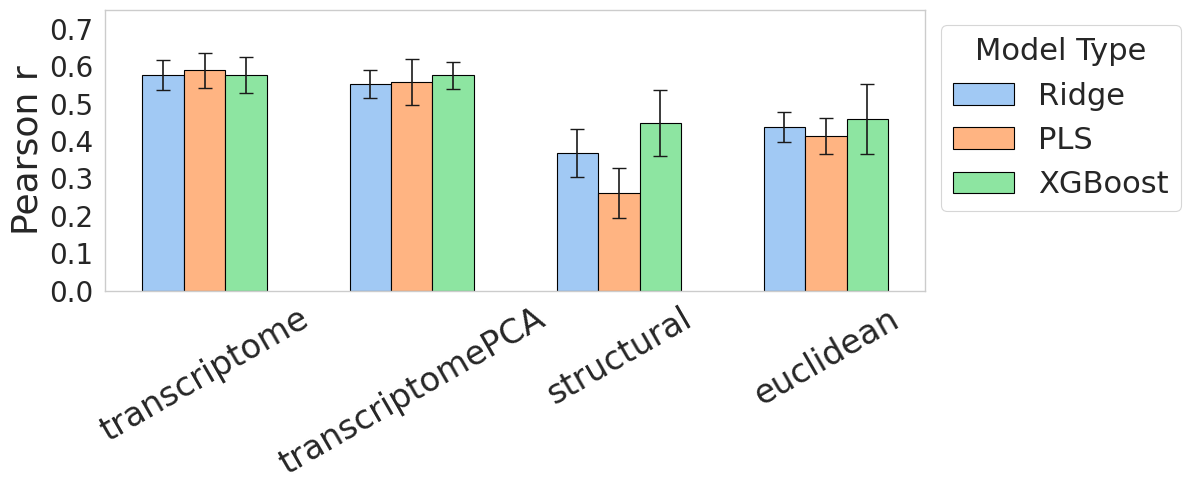

In [157]:
plot_combined_model_performance([ridge_community_df, pls_community_df, xgboost_community_df], 
                                model_types=['Ridge','PLS', 'XGBoost'], 
                                metric='pearson_corr', use_grayscale=False
                               )

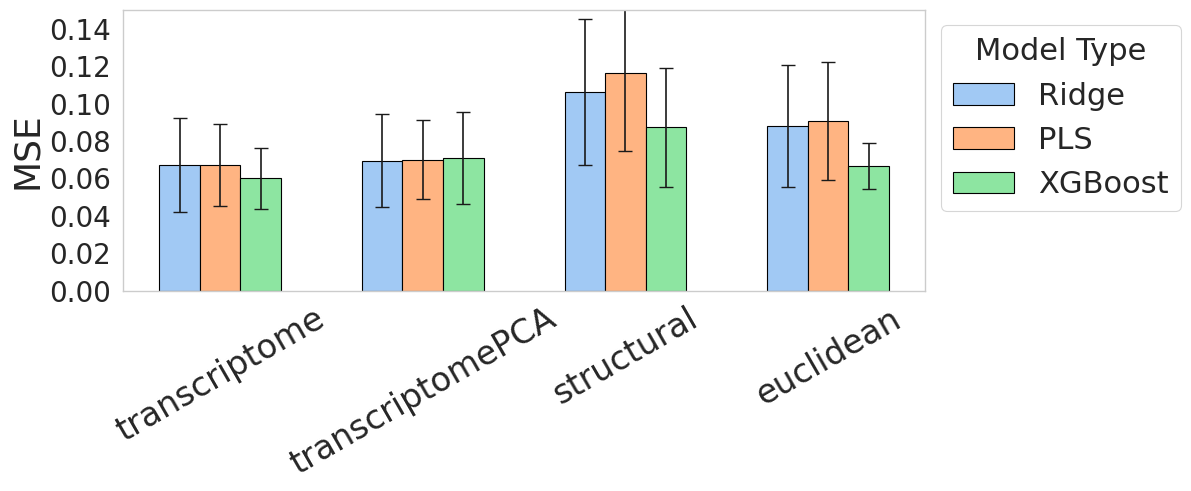

In [160]:
plot_combined_model_performance([ridge_community_df, pls_community_df, xgboost_community_df], 
                                model_types=['Ridge','PLS', 'XGBoost'], 
                                metric='mse', use_grayscale=False)

### Feature pairs and triples

In [54]:
feature_pairs = list(itertools.combinations(feature_types, 2))
feature_triples = list(itertools.combinations(feature_types, 3))

['transcriptome transcriptomePCA', 'transcriptome structural', 'transcriptome euclidean', 'transcriptomePCA structural', 'transcriptomePCA euclidean', 'structural euclidean']
                                            File Name  \
0   transcriptome transcriptomePCA_xgboost_communi...   
1   transcriptome transcriptomePCA_xgboost_communi...   
2   transcriptome transcriptomePCA_xgboost_communi...   
3   transcriptome transcriptomePCA_xgboost_communi...   
4   transcriptome transcriptomePCA_xgboost_communi...   
5   transcriptome structural_xgboost_community101_...   
6   transcriptome structural_xgboost_community101_...   
7   transcriptome structural_xgboost_community101_...   
8   transcriptome structural_xgboost_community101_...   
9   transcriptome structural_xgboost_community101_...   
10  transcriptome euclidean_xgboost_community101_1...   
11  transcriptome euclidean_xgboost_community101_2...   
12  transcriptome euclidean_xgboost_community101_4...   
13  transcriptome euclidean

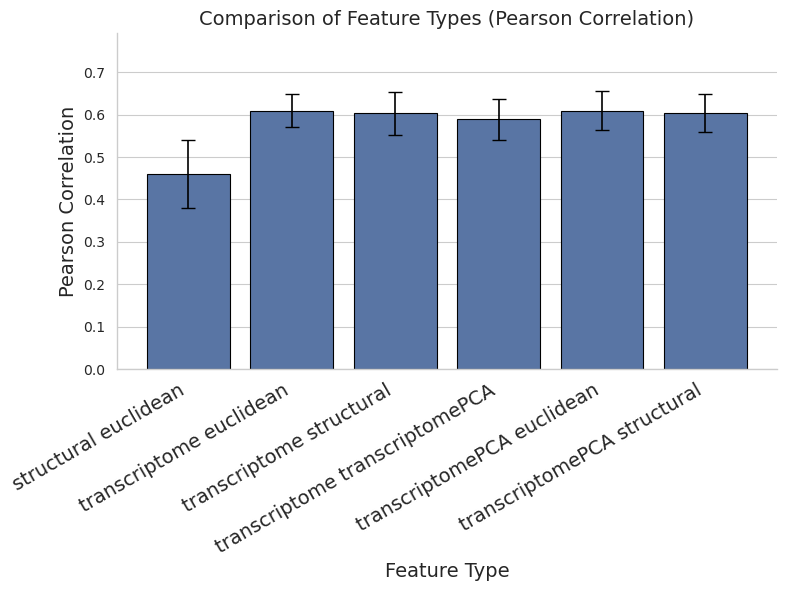

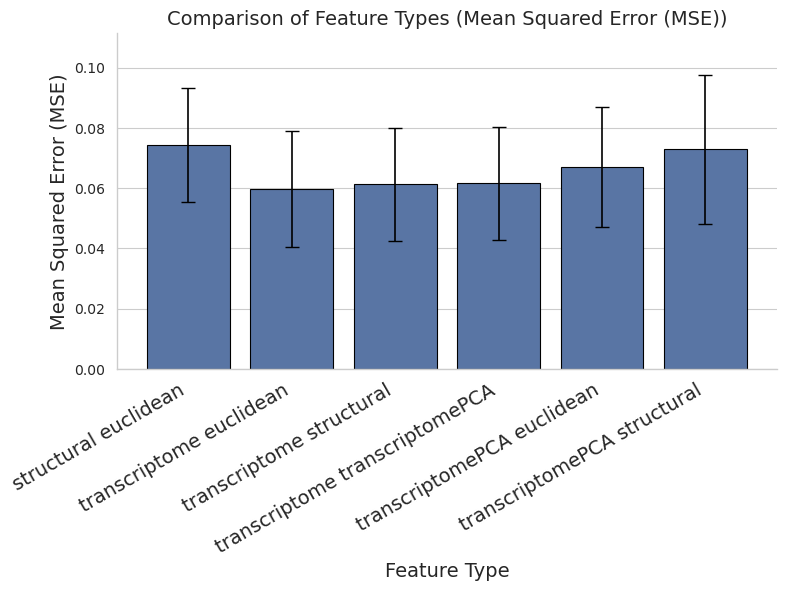

Feature Type,transcriptome transcriptomePCA,transcriptome structural,transcriptome euclidean,transcriptomePCA structural,transcriptomePCA euclidean,structural euclidean
Pearson Correlation,0.589 ± 0.049,0.602 ± 0.051,0.608 ± 0.039,0.604 ± 0.044,**0.609 ± 0.046**,0.459 ± 0.080
MSE,0.0616 ± 0.0189,0.0613 ± 0.0187,**0.0597 ± 0.0193**,0.0729 ± 0.0246,0.0670 ± 0.0200,0.0743 ± 0.0189


In [55]:
# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'community'
search_method = 'bayessearch'
feature_types = feature_pairs

# Convert each tuple to a string of format 'feature1 feature2'
feature_types = [' '.join(tup) for tup in feature_types]
print(feature_types)


resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5) 

xgboost_community_combined = display_results_table(community_split_results, feature_types=feature_types)

In [189]:

def plot_single_model_performance(df, model_type, metric='pearson_corr', feature_pairs=None, use_grayscale=True):
    """
    Plots a bar chart of model performance for a single model type across different feature pairs.
    
    Args:
    - df: DataFrame containing the results for the model.
    - model_type: The name of the model to display on the legend.
    - metric: The performance metric to plot ('pearson_corr' or 'mse').
    - feature_pairs: List of tuples containing feature pairs for x-axis labels.
    - use_grayscale: Boolean flag to switch between grayscale and soft colors.
    
    Returns:
    - A bar chart of performance metrics with error bars.
    """
    
    # Mapping metric to DataFrame row name
    metric_mapping = {
        'pearson_corr': 'Pearson Correlation',
        'mse': 'MSE'
    }
    
    # Convert string metric input to proper DataFrame row name
    metric_row_name = metric_mapping.get(metric.lower(), 'Pearson Correlation')

    # Ensure the metric is valid
    if metric_row_name not in ['Pearson Correlation', 'MSE']:
        raise ValueError("Metric must be 'pearson_corr' or 'mse'")
    
    # Extract feature types from the dataframe
    feature_types = df.columns

    # Initialize lists to store mean values and errors
    mean_values = []
    errors = []

    # Extract the values and errors from the DataFrame
    for feature in feature_types:
        # Get mean and error by splitting the "mean ± std_error" format
        value_error_str = df.loc[metric_row_name, feature].replace("**", "")
        mean_value, error_value = value_error_str.split(" ± ")
        mean_values.append(float(mean_value))
        errors.append(float(error_value))

     # Reformat feature pairs for x-axis labels with a "+" sign and newline before the "+"
    if feature_pairs:
        x_labels = ['\n+'.join(pair) for pair in feature_pairs]
    else:
        x_labels = feature_types  # Fallback to default column names if no pairs are provided

    # Set up bar chart configuration
    num_features = len(feature_types)
    bar_width = 0.8  # Wider bars
    x_indices = np.arange(num_features)

    # Set color scheme
    if use_grayscale:
        color = '#bdbdbd'  # Grayscale color
    else:
        color = sns.color_palette('pastel', 1)[0]  # Soft color from seaborn pastel palette

    # Specify the color for the bars
    custom_color = (0.5529411764705883, 0.8980392156862745, 0.6313725490196078)

    # Create the plot
    plt.figure(figsize=(16, 8))  # Bigger figure size

    # Plot the bars with error bars
    plt.bar(x_indices, mean_values, bar_width, yerr=errors, 
            label=model_type, color=custom_color, capsize=5, edgecolor='black')

    # Set x-axis labels (formatted with "+" sign) and rotate them for readability
    plt.xticks(x_indices, x_labels, rotation=30, ha='center', fontsize=26)  # Rotated and aligned right
    '''
    # Add small ticks to the x-axis for major and minor ticks
    plt.tick_params(axis='x', which='major', length=7, width=1.5)  # Bigger major ticks
    plt.tick_params(axis='x', which='minor', length=4, width=1)  # Smaller minor ticks

    # Add minor ticks explicitly
    plt.minorticks_on()
    '''
    plt.yticks(fontsize=20)  # Adjust font size
    #plt.xlabel('Feature Type', fontsize=18)  # Increase font size
    if metric_row_name == 'Pearson Correlation':    
        plt.ylabel('Pearson r', fontsize=28)  # Increase font size
    else:
        plt.ylabel(f'{metric_row_name}', fontsize=28)  # Increase font size
    #plt.legend(fontsize=16)  # Bigger font for the legend

    # Remove gridlines
    plt.grid(False)
    
    # Adjust y-axis range for Pearson correlation
    if metric == 'pearson_corr':
        plt.ylim(0.0, max(mean_values) + 0.1)  # Slightly increase the upper limit for better spacing
    else: 
        plt.ylim(0.0, 0.15)

    # Show the plot
    plt.tight_layout()
    plt.show()


'''
    # Set x-axis labels and legend
    plt.xticks(x_indices + (num_models - 1) * bar_width / 2, feature_types, fontsize=18)  # Increase font size
    plt.yticks(fontsize=20)  # Increase font size
    #plt.xlabel('Feature Type', fontsize=16)  # Increase font size
    plt.ylabel(f'{metric_row_name}', fontsize=24)  # Increase font size
    #plt.title(f'Model Performance Comparison ({metric_row_name})', fontsize=18)  # Increase font size

    # Move legend outside the plot
    plt.legend(title='Model Type', fontsize=20, title_fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside plot
'''

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_single_model_performance(df, model_type, metric='pearson_corr', feature_pairs=None):
#     """
#     Plots a bar chart of model performance for a single model type across different feature pairs.
    
#     Args:
#     - df: DataFrame containing the results for the model.
#     - model_type: The name of the model to display on the legend.
#     - metric: The performance metric to plot ('pearson_corr' or 'mse').
#     - feature_pairs: List of tuples containing feature pairs for x-axis labels.
    
#     Returns:
#     - A bar chart of performance metrics with error bars.
#     """
    
#     # Mapping metric to DataFrame row name
#     metric_mapping = {
#         'pearson_corr': 'Pearson Correlation',
#         'mse': 'MSE'
#     }
    
#     # Convert string metric input to proper DataFrame row name
#     metric_row_name = metric_mapping.get(metric.lower(), 'Pearson Correlation')

#     # Ensure the metric is valid
#     if metric_row_name not in ['Pearson Correlation', 'MSE']:
#         raise ValueError("Metric must be 'pearson_corr' or 'mse'")
    
#     # Extract feature types from the dataframe
#     feature_types = df.columns

#     # Initialize lists to store mean values and errors
#     mean_values = []
#     errors = []

#     # Extract the values and errors from the DataFrame
#     for feature in feature_types:
#         # Get mean and error by splitting the "mean ± std_error" format
#         value_error_str = df.loc[metric_row_name, feature].replace("**", "")
#         mean_value, error_value = value_error_str.split(" ± ")
#         mean_values.append(float(mean_value))
#         errors.append(float(error_value))

#     # Reformat feature pairs for x-axis labels with a "+" sign
#     if feature_pairs:
#         x_labels = ['+'.join(pair) for pair in feature_pairs]
#     else:
#         x_labels = feature_types  # Fallback to default column names if no pairs are provided

#     # Set up bar chart configuration
#     num_features = len(feature_types)
#     bar_width = 0.8  # Wider bars
#     x_indices = np.arange(num_features)

#     # Create the plot
#     plt.figure(figsize=(12, 8))  # Bigger figure size

#     # Plot the bars with error bars
#     plt.bar(x_indices, mean_values, bar_width, yerr=errors, 
#             label=model_type, color='#bdbdbd', capsize=5, edgecolor='black')

#     # Set x-axis labels (formatted with "+" sign) and rotate them for readability
#     plt.xticks(x_indices, x_labels, rotation=45, ha='right', fontsize=14)  # Rotated and aligned right
#     plt.yticks(fontsize=14)  # Rotated and aligned right
#     plt.xlabel('Feature Type', fontsize=16)  # Increase font size
#     plt.ylabel(f'{metric_row_name}', fontsize=16)  # Increase font size
#     plt.legend(fontsize=14)  # Bigger font for the legend

#     # Remove gridlines
#     plt.grid(False)
    
#     # Adjust y-axis range for Pearson correlation
#     if metric == 'pearson_corr':
#         plt.ylim(0.0, max(mean_values) + 0.1)  # Slightly increase the upper limit for better spacing

#     # Show the plot
#     plt.tight_layout()
#     plt.show()


"\n    # Set x-axis labels and legend\n    plt.xticks(x_indices + (num_models - 1) * bar_width / 2, feature_types, fontsize=18)  # Increase font size\n    plt.yticks(fontsize=20)  # Increase font size\n    #plt.xlabel('Feature Type', fontsize=16)  # Increase font size\n    plt.ylabel(f'{metric_row_name}', fontsize=24)  # Increase font size\n    #plt.title(f'Model Performance Comparison ({metric_row_name})', fontsize=18)  # Increase font size\n\n    # Move legend outside the plot\n    plt.legend(title='Model Type', fontsize=20, title_fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside plot\n"

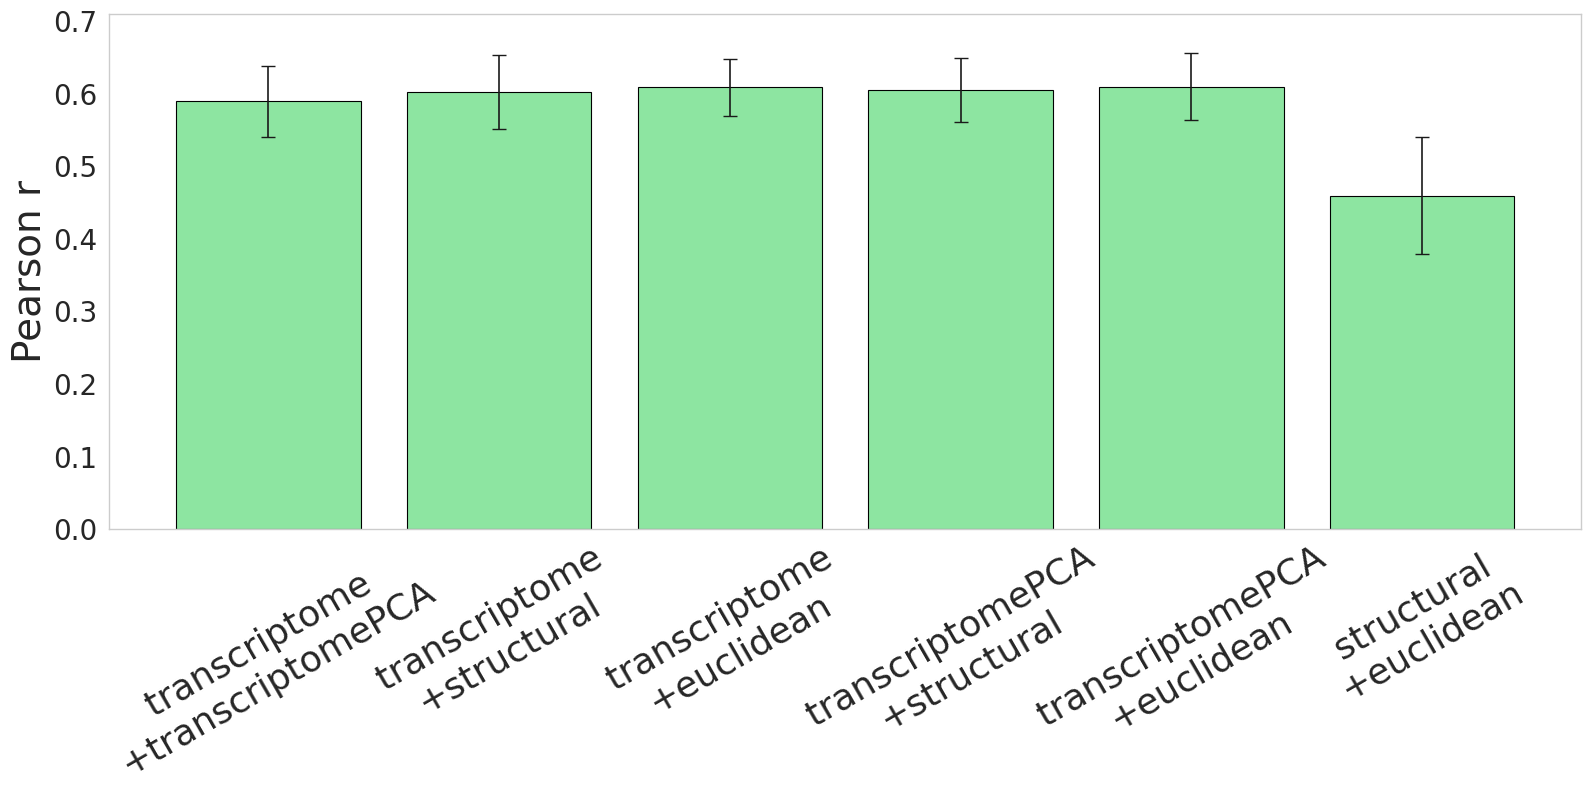

In [190]:

# Example usage with your single model dataframe
plot_single_model_performance(xgboost_community_combined, 'XGBoost', 'pearson_corr', feature_pairs, use_grayscale=False)

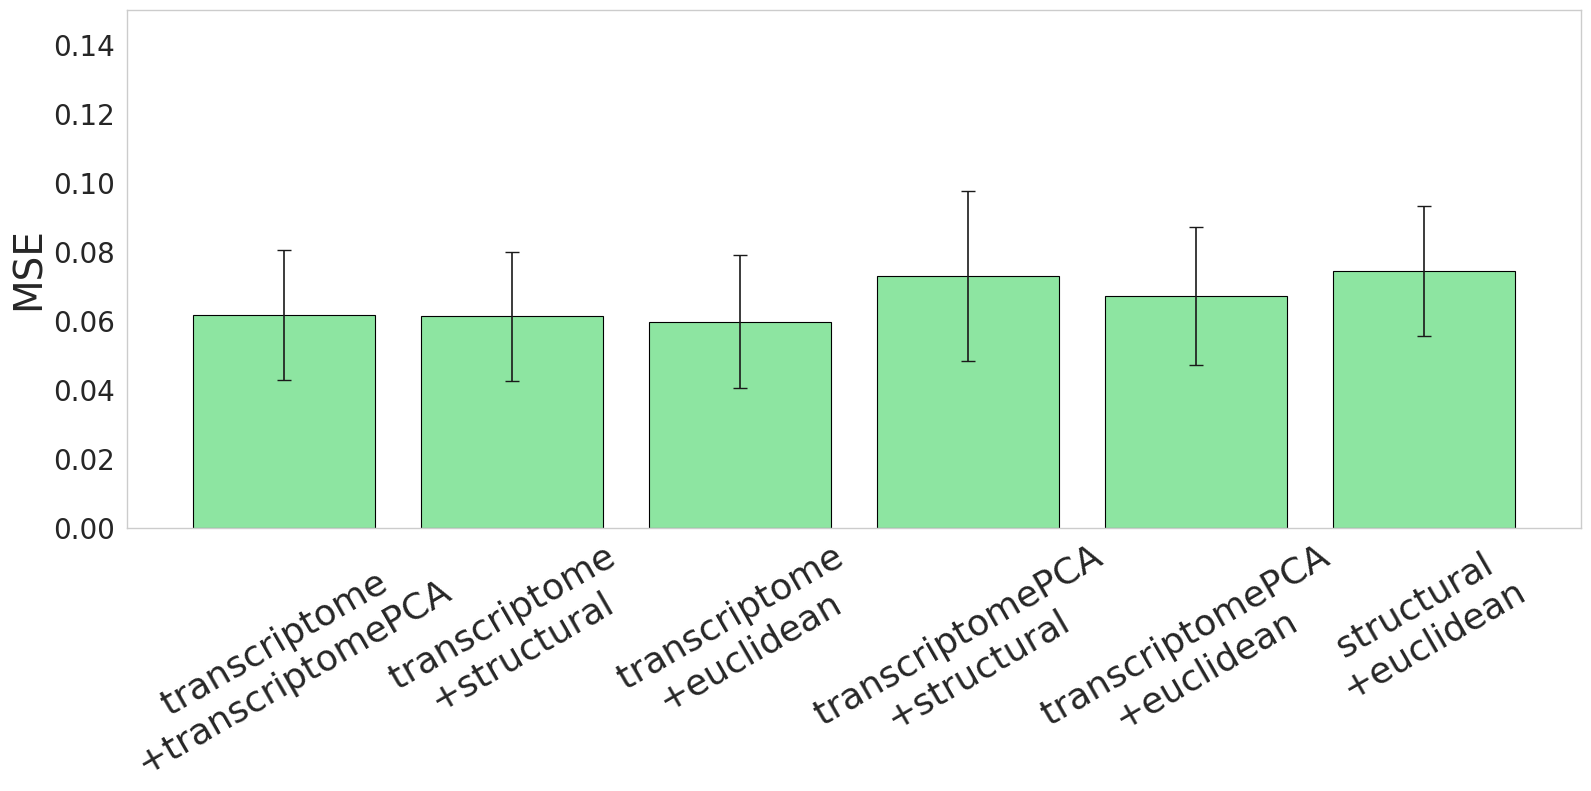

In [191]:

# Example usage with your single model dataframe
plot_single_model_performance(xgboost_community_combined, 'XGBoost', 'mse', feature_pairs, use_grayscale=False)


In [27]:
import numpy as np
import pandas as pd

def bold_best_value(df, metric='pearson_corr', feature_pairs=None):
    """
    Function to output a DataFrame where the highest value in Pearson correlation and 
    the lowest value in MSE is bolded. 
    
    Args:
    - df: DataFrame with the feature types and their corresponding metrics.
    - metric: Performance metric to use ('pearson_corr' or 'mse').
    - feature_pairs: List of feature pairs to reformat the feature names.
    
    Returns:
    - A DataFrame with the best values bolded.
    """
    
    # Mapping metric to DataFrame row name
    metric_mapping = {
        'pearson_corr': 'Pearson Correlation',
        'mse': 'MSE'
    }
    
    # Convert string metric input to proper DataFrame row name
    metric_row_name = metric_mapping.get(metric.lower(), 'Pearson Correlation')
    
    # Extract feature types
    feature_types = df.columns
    
    # Initialize lists to store mean values and errors
    mean_values = []
    
    # Extract the values and errors from the DataFrame
    for feature in feature_types:
        value_error_str = df.loc[metric_row_name, feature].replace("**", "")
        mean_value, _ = value_error_str.split(" ± ")
        mean_values.append(float(mean_value))
    
    # Determine the best value (highest for Pearson Correlation, lowest for MSE)
    if metric == 'pearson_corr':
        best_idx = np.argmax(mean_values)  # Index of the highest Pearson correlation
    elif metric == 'mse':
        best_idx = np.argmin(mean_values)  # Index of the lowest MSE
    else:
        raise ValueError("Metric must be 'pearson_corr' or 'mse'")
    
    # Bold the best value
    for i, feature in enumerate(feature_types):
        if i == best_idx:
            df.loc[metric_row_name, feature] = f"**{df.loc[metric_row_name, feature].replace('**', '')}**"
    
    # Reformat feature pairs for the DataFrame columns
    if feature_pairs:
        df.columns = ['+'.join(pair) for pair in feature_pairs]
    
    return df

# Example usage with your single model dataframe
bolded_df = bold_best_value(xgboost_community_combined, metric='pearson_corr', feature_pairs=feature_pairs)
display(bolded_df)  # This displays the DataFrame in a notebook-friendly format

,transcriptome+transcriptomePCA,transcriptome+structural,transcriptome+euclidean,transcriptomePCA+structural,transcriptomePCA+euclidean,structural+euclidean
Pearson Correlation,0.589 ± 0.049,0.602 ± 0.051,0.608 ± 0.039,0.604 ± 0.044,**0.609 ± 0.046**,0.459 ± 0.080
MSE,0.0616 ± 0.0189,0.0613 ± 0.0187,**0.0597 ± 0.0193**,0.0729 ± 0.0246,0.0670 ± 0.0200,0.0743 ± 0.0189


In [28]:
# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'community'
search_method = 'bayessearch'
feature_types = feature_triples

# Convert each tuple to a string of format 'feature1 feature2'
feature_types = [' '.join(tup) for tup in feature_types]
print(feature_types)


resolutions = []  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5) 

display_results_table(community_split_results, feature_types=feature_types)

['transcriptome transcriptomePCA structural', 'transcriptome transcriptomePCA euclidean', 'transcriptome structural euclidean', 'transcriptomePCA structural euclidean']
File not found: transcriptome transcriptomePCA structural_xgboost_community_1_bayessearch.pickle
File not found: transcriptome transcriptomePCA structural_xgboost_community_2_bayessearch.pickle
File not found: transcriptome transcriptomePCA structural_xgboost_community_4_bayessearch.pickle
File not found: transcriptome transcriptomePCA structural_xgboost_community_5_bayessearch.pickle
File not found: transcriptome transcriptomePCA structural_xgboost_community_42_bayessearch.pickle
File not found: transcriptome transcriptomePCA euclidean_xgboost_community_1_bayessearch.pickle
File not found: transcriptome transcriptomePCA euclidean_xgboost_community_2_bayessearch.pickle
File not found: transcriptome transcriptomePCA euclidean_xgboost_community_4_bayessearch.pickle
File not found: transcriptome transcriptomePCA euclidean_

KeyError: 'Feature Type'

#### Back to random

In [ ]:
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

In [47]:
feature_pairs = list(itertools.combinations(feature_types, 2))
feature_triples = list(itertools.combinations(feature_types, 3))

['transcriptome transcriptomePCA', 'transcriptome structural', 'transcriptome euclidean', 'transcriptomePCA structural', 'transcriptomePCA euclidean', 'structural euclidean']
File not found: transcriptome transcriptomePCA_xgboost_random_1_bayessearch.pickle
File not found: transcriptome transcriptomePCA_xgboost_random_2_bayessearch.pickle
File not found: transcriptome transcriptomePCA_xgboost_random_3_bayessearch.pickle
File not found: transcriptome transcriptomePCA_xgboost_random_4_bayessearch.pickle
File not found: transcriptome transcriptomePCA_xgboost_random_5_bayessearch.pickle
File not found: transcriptome transcriptomePCA_xgboost_random_6_bayessearch.pickle
File not found: transcriptome transcriptomePCA_xgboost_random_7_bayessearch.pickle
File not found: transcriptome transcriptomePCA_xgboost_random_8_bayessearch.pickle
File not found: transcriptome transcriptomePCA_xgboost_random_9_bayessearch.pickle
File not found: transcriptome structural_xgboost_random_1_bayessearch.pickle
F

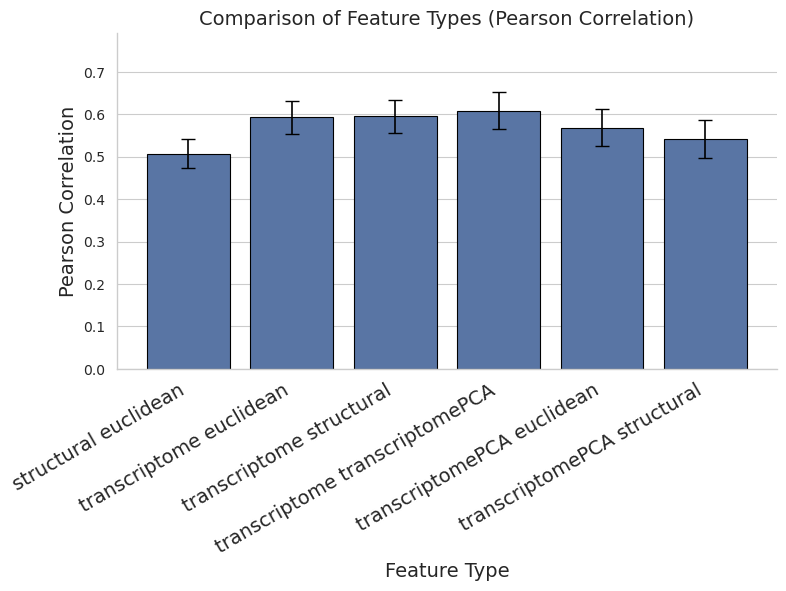

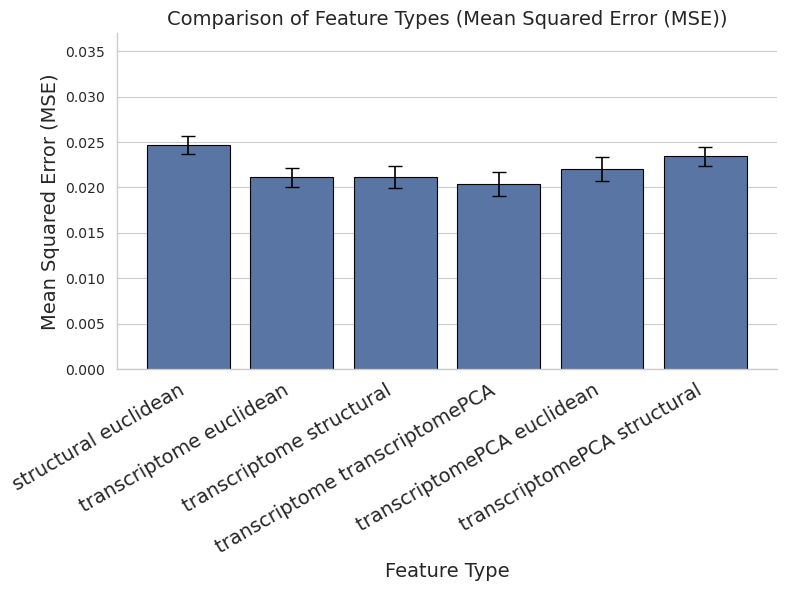

KeyError: 'Feature Type'

In [48]:
# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'random'
search_method = 'bayessearch'
feature_types = feature_pairs

# Convert each tuple to a string of format 'feature1 feature2'
feature_types = [' '.join(tup) for tup in feature_types]
print(feature_types)


resolutions = []  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]  # List of seeds

random_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(random_split_results)

plot_feature_comparison(random_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(random_split_results, metric='mse', margin_factor=0.5) 

xgb_combined_random = display_results_table(community_split_results, feature_types=feature_types)

In [38]:
# Specify parameters
subfolder = ''
model_type = 'pls'
cv_type = 'random'
search_method = 'gridsearch'
feature_types = feature_pairs

# Convert each tuple to a string of format 'feature1 feature2'
feature_types = [' '.join(tup) for tup in feature_types]
print(feature_types)


resolutions = []  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]  # List of seeds

random_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(random_split_results)

plot_feature_comparison(random_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(random_split_results, metric='mse', margin_factor=0.5) 

pls_combined_random = display_results_table(community_split_results, feature_types=feature_types)

['transcriptome transcriptomePCA transcriptome structural', 'transcriptome transcriptomePCA transcriptome euclidean', 'transcriptome transcriptomePCA transcriptomePCA structural', 'transcriptome transcriptomePCA transcriptomePCA euclidean', 'transcriptome transcriptomePCA structural euclidean', 'transcriptome structural transcriptome euclidean', 'transcriptome structural transcriptomePCA structural', 'transcriptome structural transcriptomePCA euclidean', 'transcriptome structural structural euclidean', 'transcriptome euclidean transcriptomePCA structural', 'transcriptome euclidean transcriptomePCA euclidean', 'transcriptome euclidean structural euclidean', 'transcriptomePCA structural transcriptomePCA euclidean', 'transcriptomePCA structural structural euclidean', 'transcriptomePCA euclidean structural euclidean']
File not found: transcriptome transcriptomePCA transcriptome structural_pls_random_1_gridsearch.pickle
File not found: transcriptome transcriptomePCA transcriptome structural

KeyError: 'Feature Type'

In [9]:
# Specify parameters
subfolder = ''
model_type = 'ridge'
cv_type = 'random'
search_method = 'gridsearch'
feature_types = feature_pairs

# Convert each tuple to a string of format 'feature1 feature2'
feature_types = [' '.join(tup) for tup in feature_types]
print(feature_types)


#resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]  # List of seeds

random_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(random_split_results)

plot_feature_comparison(random_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(random_split_results, metric='mse', margin_factor=0.5) 

ridge_combined_random = display_results_table(community_split_results, feature_types=feature_types)

NameError: name 'feature_pairs' is not defined

In [6]:
plot_combined_model_performance([ridge_combined_random, pls_combined_random, xgboost_combined_random], 
                                model_types=['Ridge', 'PLS', 'XGBoost'], 
                                metric='pearson_corr')

NameError: name 'plot_combined_model_performance' is not defined